In [5]:
%load_ext autoreload
%autoreload 2

import sys
import os

# Get current working directory (where notebook is running)
current_dir = os.getcwd()
# Go up one level, then into utils
utils_path = os.path.abspath(os.path.join(current_dir, '..', 'utils'))
# Add to sys.path
sys.path.append(utils_path)

from trend_regime_utils import load_trend_data, process_trend_data, create_advanced_feat, mayority_vote_cluster_smooth

import pandas as pd
import numpy as np
from datetime import datetime
from zoneinfo import ZoneInfo
import joblib
from scipy.stats.mstats import winsorize

# For API Keys
from dotenv import load_dotenv
# Alpaca API keys
API_KEY = None
SECRET_KEY = None

load_dotenv(override=True)

if API_KEY is None:
    API_KEY = os.environ.get('ALP_API_KEY')

if SECRET_KEY is None:
    SECRET_KEY = os.environ.get('ALP_SEC_KEY')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
EARLIEST_DATE = datetime(2016, 1, 16, tzinfo=ZoneInfo('America/New_York'))
LAST_DATE = datetime(2025, 7, 20, tzinfo=ZoneInfo('America/New_York'))

df_trend_raw = load_trend_data(API_KEY, SECRET_KEY, EARLIEST_DATE, LAST_DATE)

df_trend_processed = process_trend_data(df_trend_raw)

df_trend_feat = create_advanced_feat(df_trend_processed)

c:\Users\sergi\Documents\TFG\utils\trend_regime_utils.py:96: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_feat = df_subset.groupby('symbol').apply(compute_trend_features)
c:\Users\sergi\Documents\TFG\utils\trend_regime_utils.py:96: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_feat = df_subset.groupby('symbol').apply(compute_trend_features)
c:\Users\sergi\Documents\TFG\utils\trend_regime_utils.py:96: FutureWar

In [7]:
# Get the project root (one level up from current working directory)
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
MODEL_DIR = os.path.join(PROJECT_ROOT, 'models')

os.makedirs(MODEL_DIR, exist_ok=True)

## If want to predict
# Load models
scaler = joblib.load(os.path.join(MODEL_DIR, "trend_scaler.pkl"))
umap_model = joblib.load(os.path.join(MODEL_DIR, "trend_umap_model.pkl"))
gmm_model = joblib.load(os.path.join(MODEL_DIR, "trend_gmm_model.pkl"))

# scale data
trend_scaled = scaler.transform(df_trend_feat)

# Apply UMAP transformation
trend_umap = umap_model.transform(trend_scaled)

# Predict clusters
trend_gmm_labels = gmm_model.predict(trend_umap)

# from sklearn.metrics import silhouette_score
# print(silhouette_score(trend_umap, trend_gmm_labels))

df_with_clusters = pd.DataFrame(trend_gmm_labels, columns=["cluster"], index=df_trend_feat.index)

df_cluster_smooth = mayority_vote_cluster_smooth(df_with_clusters)

In [8]:
# PCA + Spectral
# UMAP + HDBSCAN

In [9]:
# Example list – customize based on your actual dataset
us_global_equities = ['SPY', 'QQQ', 'DIA', 'IWM', 'EFA', 'EEM', 'VEA', 'VWO']
other_tickers = ['TLT', 'GLD', 'VIXM', 'SPHB', 'SPLV']
bull_tickers = us_global_equities+other_tickers
df_bull_raw = load_trend_data(API_KEY, SECRET_KEY, EARLIEST_DATE, LAST_DATE, all_tickers=bull_tickers)

print(df_bull_raw.pivot(columns='symbol').isna().sum())

      symbol
open  DIA       0
      EEM       0
      EFA       0
      GLD       0
      IWM       0
               ..
vwap  SPY       0
      TLT       0
      VEA       0
      VIXM      0
      VWO       0
Length: 91, dtype: int64


In [10]:
# --- Configuration ---
ROLLING_WINDOW = 20  # You can adjust this

# --- Filter SPY Data ---
df_eq = df_bull_raw[df_bull_raw['symbol'].isin(us_global_equities)].sort_index().copy()
df_eq_mean = df_eq.groupby(df_eq.index).mean(numeric_only=True)

# --- Feature 1: Trend Consistency Score ---
df_eq_mean['trend_consistency'] = ((df_eq_mean['close'] - df_eq_mean['low']) / 
                                (df_eq_mean['high'] - df_eq_mean['low'] + 1e-6)).rolling(ROLLING_WINDOW).mean()

# --- Feature 2: Volatility Asymmetry Index ---
returns = df_eq_mean['close'].pct_change()

def upside_vol_func(returns_window):
    pos_returns = returns_window[returns_window > 0]
    if len(pos_returns) >= 2:  # needs at least 2 points for std
        return pos_returns.std()
    else:
        return np.nan

upside_vol = returns.rolling(ROLLING_WINDOW).apply(upside_vol_func, raw=False)
total_vol = returns.rolling(ROLLING_WINDOW).std()
df_eq_mean['vol_asymmetry'] = upside_vol / (total_vol + 1e-6)

# --- Feature 6: Higher High Consistency ---
higher_high = (df_eq_mean['high'] > df_eq_mean['high'].shift(1)).astype(int)
df_eq_mean['higher_high_consistency'] = higher_high.rolling(ROLLING_WINDOW).mean()

# --- Feature 8: Volume Trend Divergence ---
df_eq_mean['volume_trend_divergence'] = (
    df_eq_mean['close'].pct_change().rolling(ROLLING_WINDOW)
    .corr(df_eq_mean['volume'].rolling(ROLLING_WINDOW).mean())
)


In [11]:
# --- Helper function to extract close price of a symbol ---
def get_close(symbol):
    return df_bull_raw[df_bull_raw['symbol'] == symbol].sort_index()['close']

# Get closes for external tickers
tlt = get_close('TLT')
gld = get_close('GLD')
vixm = get_close('VIXM')
sphb = get_close('SPHB')
splv = get_close('SPLV')

# Align all external data to SPY's index
external_df = pd.DataFrame(index=df_eq_mean.index)

# --- Feature 7: Correlations ---
external_df['glob_eq_tlt_corr'] = df_eq_mean['close'].pct_change().rolling(ROLLING_WINDOW).corr(tlt.pct_change())
external_df['glob_eq_gld_corr'] = df_eq_mean['close'].pct_change().rolling(ROLLING_WINDOW).corr(gld.pct_change())

# --- Feature 9: Implied Volatility Drift (from VIXM) ---
external_df['vixm_drift'] = vixm.pct_change().rolling(ROLLING_WINDOW).mean()

# --- Feature 10: High Beta vs. Low Volatility Spread ---
external_df['beta_vol_spread'] = sphb.pct_change().rolling(ROLLING_WINDOW).mean() - \
                                  splv.pct_change().rolling(ROLLING_WINDOW).mean()

In [12]:
# Combine SPY-only features and external features
bull_features_df = pd.concat([df_eq_mean[['trend_consistency', 'vol_asymmetry', 
                                 'higher_high_consistency', 'volume_trend_divergence']],
                         external_df], axis=1)

# Optional: Drop rows with missing values
print(bull_features_df.isna().sum())
bull_features_df.dropna(inplace=True)

trend_consistency          19
vol_asymmetry              20
higher_high_consistency    19
volume_trend_divergence    38
glob_eq_tlt_corr           20
glob_eq_gld_corr           20
vixm_drift                 20
beta_vol_spread            20
dtype: int64


In [13]:
# keep only bull days 
bull_days = df_cluster_smooth[df_cluster_smooth==1]

# Keep only rows in bull_features_df where the index exists in bull_days
only_bull_features_df = bull_features_df[bull_features_df.index.isin(bull_days.index)]
aux_df = only_bull_features_df.copy()
only_bull_features_df.shape

(864, 8)

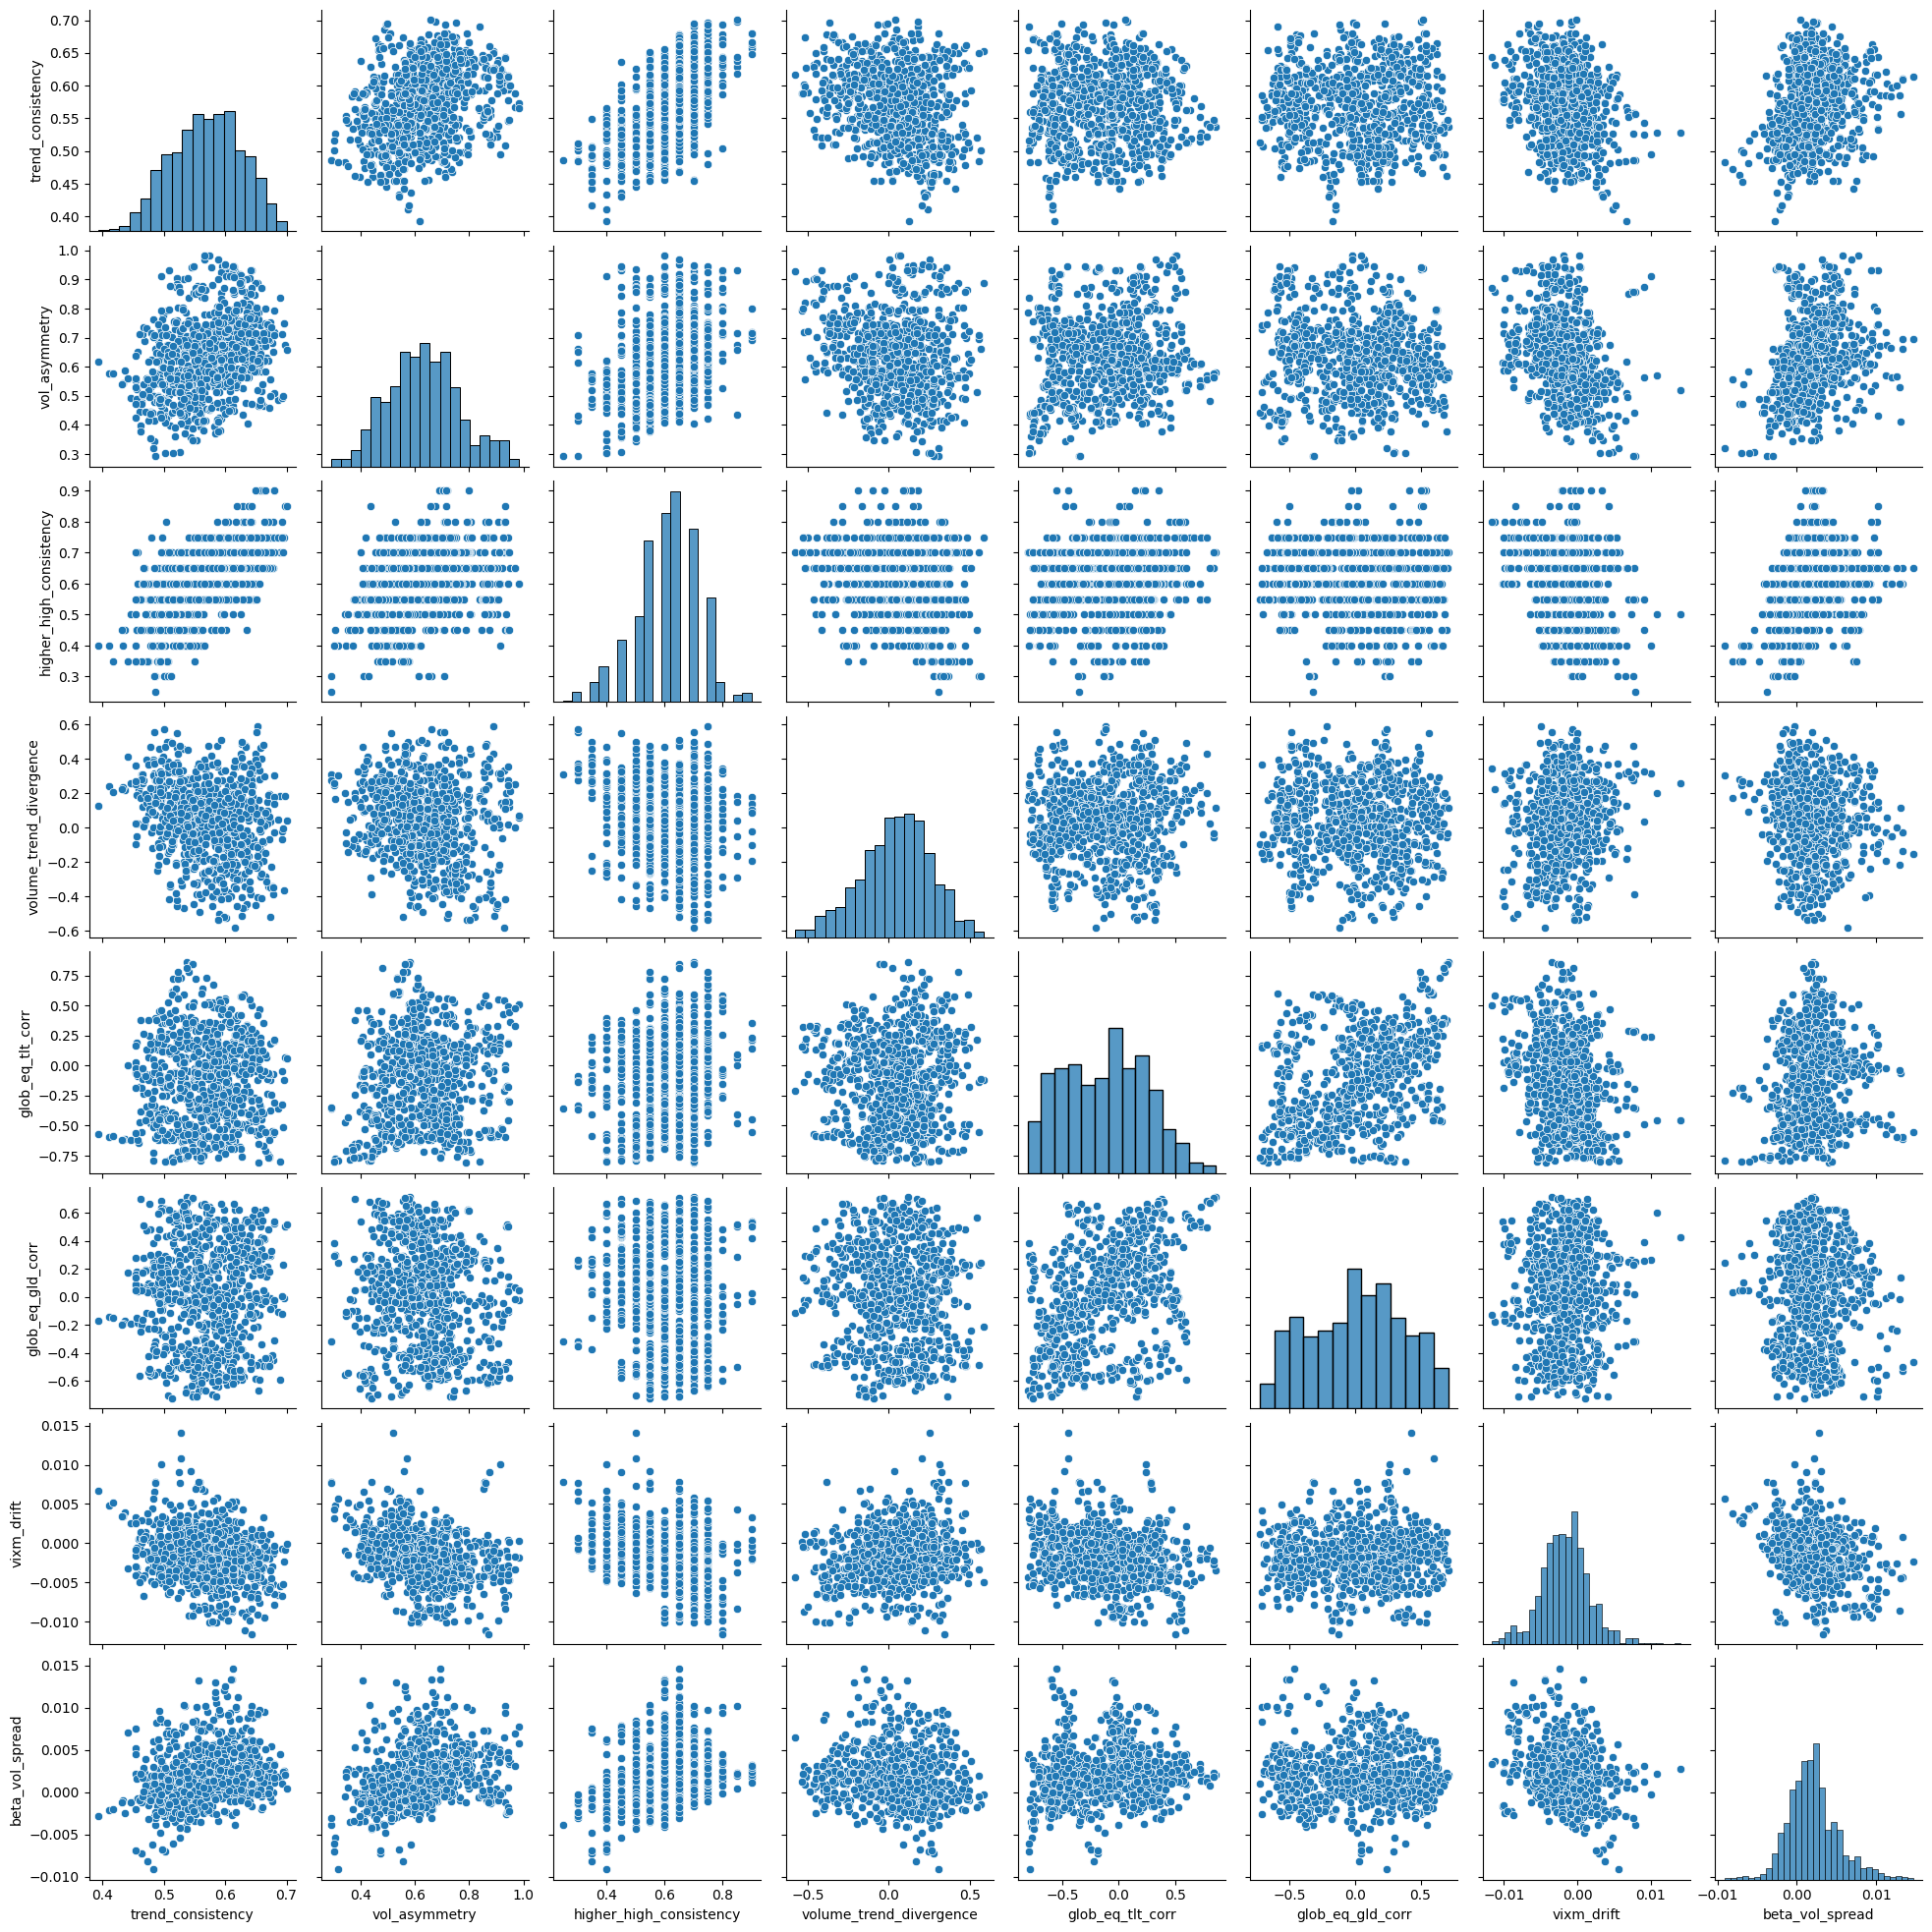

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
# Pairwise scatter plots
sns.pairplot(aux_df)
plt.show()

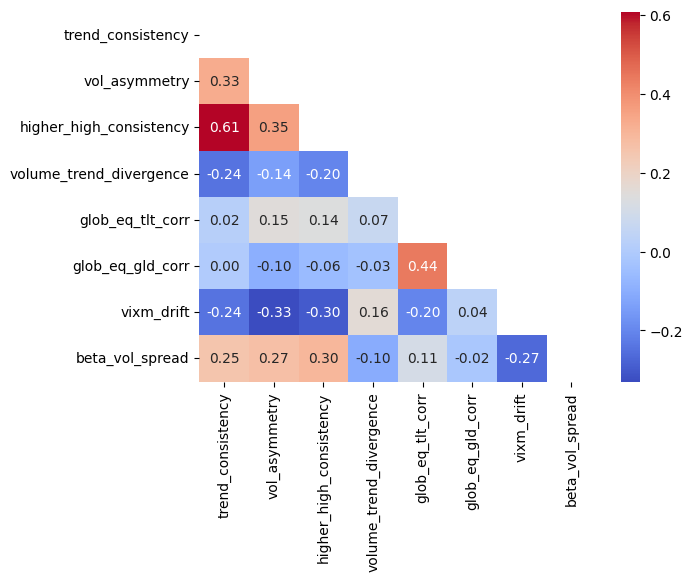

In [15]:
# Compute correlation matrix
corr = aux_df.corr()

# Mask upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot heatmap
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [ ]:
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from tqdm import tqdm
import pandas as pd
import numpy as np
import umap


# --- Parameters ---
fixed_feats = ['glob_eq_tlt_corr', 'glob_eq_gld_corr']
aux_df_cols = aux_df.columns.tolist()
other_cols = [col for col in aux_df_cols if col not in fixed_feats]

N_COMP = 3
N_NEIGs = [10, 20, 40]
MIN_Ds = [0.01, 0.1, 0.2]
METRICs = ["euclidean", "manhattan", "correlation"]
RANDOM_STATE = 4

# --- Generate Feature Combinations ---
feat_combos = []
# Combinations of 1 other column + fixed features
for col in other_cols:
    feat_combos.append(fixed_feats + [col])
# Combinations of 3 other columns + fixed features
for combo in combinations(other_cols, 3):
    feat_combos.append(fixed_feats + list(combo))

# Store results
results = []

# --- Grid Search Loop ---
for features in tqdm(feat_combos, desc="Feature Combinations"):
    # Select and scale the features for the current combination
    current_df = aux_df[features]
    scaled = StandardScaler().fit_transform(current_df.values)

    for N_NEIG in N_NEIGs:
        for MIN_D in MIN_Ds:
            for METRIC in METRICs:
                # Apply UMAP
                X_umap = umap.UMAP(
                    n_neighbors=N_NEIG,
                    min_dist=MIN_D,
                    n_components=N_COMP,
                    metric=METRIC,
                    random_state=RANDOM_STATE
                ).fit_transform(scaled)

                try:
                    model = SpectralClustering(
                        n_clusters=2,
                        affinity='rbf',
                        assign_labels='kmeans',
                        random_state=RANDOM_STATE
                    )
                    labels = model.fit_predict(X_umap)

                    sil = silhouette_score(X_umap, labels)
                    ch = calinski_harabasz_score(X_umap, labels)
                    db = davies_bouldin_score(X_umap, labels)

                    # Compute cluster distribution
                    unique, counts = np.unique(labels, return_counts=True)
                    proportions = counts / len(labels)
                    cluster_distribution = tuple(proportions[np.argsort(unique)])

                    results.append({
                        'features': features, # Added the current feature set to results
                        'metric_umap': METRIC,
                        'n_neig_umap': N_NEIG,
                        'min_d_umap': MIN_D,
                        'silhouette': sil,
                        'calinski_harabasz': ch,
                        'davies_bouldin': db,
                        'cluster_distribution': cluster_distribution
                    })
                except Exception as e:
                    print(f"Skipping combination {features} with UMAP params: {N_NEIG}, {MIN_D}, {METRIC} due to error: {e}")
                    continue

# Convert to DataFrame
grid_df = pd.DataFrame(results)
grid_df.to_csv("bull_spectral_search.csv")

Feature Combinations:   0%|          | 0/26 [00:00<?, ?it/s]c:\Users\sergi\Documents\TFG\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\sergi\Documents\TFG\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\sergi\Documents\TFG\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\sergi\Documents\TFG\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited at iteration 467 with accuracies 
[1.03897990e-15 1.39015167e-05 1.25853806e-05]
not reaching the requested tolerance 1.2874603271484375e-05.
Use iteration 377 instead with accuracy 
7.76221176219562e-06.

  _, diffusion_map = lobpcg(
c:\Users\sergi\Documents\TFG\.venv\Lib\site-packag

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

grid_df[(grid_df['cluster_distribution'].apply(lambda x: max(x) < 0.75)) & (grid_df['features'].apply(lambda x: len(x) > 3))
       & (grid_df['features'].apply(lambda x: 'beta_vol_spread' not in x)) & (grid_df['metric_umap'] == "correlation")].sort_values(by='silhouette', ascending=False)\
 .reset_index(drop=True).head(20)

,features,metric_umap,n_neig_umap,min_d_umap,silhouette,calinski_harabasz,davies_bouldin,cluster_distribution
0,"[glob_eq_tlt_corr, glob_eq_gld_corr, trend_consistency, vol_asymmetry, volume_trend_divergence]",correlation,10,0.01,0.491029,1044.902344,0.832384,"(0.41203703703703703, 0.5879629629629629)"
1,"[glob_eq_tlt_corr, glob_eq_gld_corr, trend_consistency, higher_high_consistency, vixm_drift]",correlation,40,0.01,0.479941,916.258179,0.896303,"(0.5335648148148148, 0.4664351851851852)"
2,"[glob_eq_tlt_corr, glob_eq_gld_corr, vol_asymmetry, higher_high_consistency, vixm_drift]",correlation,10,0.01,0.474504,832.488464,0.896235,"(0.38078703703703703, 0.6192129629629629)"
3,"[glob_eq_tlt_corr, glob_eq_gld_corr, vol_asymmetry, higher_high_consistency, vixm_drift]",correlation,10,0.10,0.457027,784.897705,0.936169,"(0.38078703703703703, 0.6192129629629629)"
4,"[glob_eq_tlt_corr, glob_eq_gld_corr, trend_consistency, vol_asymmetry, higher_high_consistency]",correlation,40,0.01,0.455896,898.398865,0.891751,"(0.3738425925925926, 0.6261574074074074)"
5,"[glob_eq_tlt_corr, glob_eq_gld_corr, trend_consistency, higher_high_consistency, vixm_drift]",correlation,10,0.01,0.452471,794.806274,0.981711,"(0.4351851851851852, 0.5648148148148148)"
6,"[glob_eq_tlt_corr, glob_eq_gld_corr, vol_asymmetry, higher_high_consistency, vixm_drift]",correlation,20,0.01,0.449810,825.168701,0.858922,"(0.3287037037037037, 0.6712962962962963)"
7,"[glob_eq_tlt_corr, glob_eq_gld_corr, trend_consistency, vol_asymmetry, higher_high_consistency]",correlation,20,0.01,0.444539,789.836670,0.938324,"(0.6585648148148148, 0.3414351851851852)"
8,"[glob_eq_tlt_corr, glob_eq_gld_corr, trend_consistency, vol_asymmetry, vixm_drift]",correlation,40,0.20,0.441727,785.057251,0.925394,"(0.6631944444444444, 0.3368055555555556)"
9,"[glob_eq_tlt_corr, glob_eq_gld_corr, trend_consistency, higher_high_consistency, volume_trend_divergence]",correlation,20,0.01,0.441672,766.329712,0.991445,"(0.5173611111111112, 0.4826388888888889)"


In [280]:
only_bull_features_df  = aux_df[["glob_eq_tlt_corr", "glob_eq_gld_corr","trend_consistency",  "higher_high_consistency","vol_asymmetry"]]

N_COMP=3
N_NEIG=55
MIN_D = 0.01
METRIC = "correlation"

RANDOM_STATE = 4

K=2

from itertools import combinations
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap


# Store results
results = []

scaled = StandardScaler().fit_transform(only_bull_features_df.values)

# Apply UMAP
X_umap = umap.UMAP(
    n_neighbors=N_NEIG,
    min_dist=MIN_D,
    n_components=N_COMP,
    metric=METRIC,
    random_state=RANDOM_STATE
).fit_transform(scaled)

model = SpectralClustering(
    n_clusters=K,
    affinity='rbf',
    assign_labels='kmeans',
    random_state=RANDOM_STATE
)
labels = model.fit_predict(X_umap)

sil = silhouette_score(X_umap, labels)
ch = calinski_harabasz_score(X_umap, labels)
db = davies_bouldin_score(X_umap, labels)
print("silhouette_score", sil)

c:\Users\sergi\Documents\TFG\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


silhouette_score 0.47670358419418335


In [281]:
pd.Series(labels).value_counts(normalize=True)

1    0.635417
0    0.364583
Name: proportion, dtype: float64

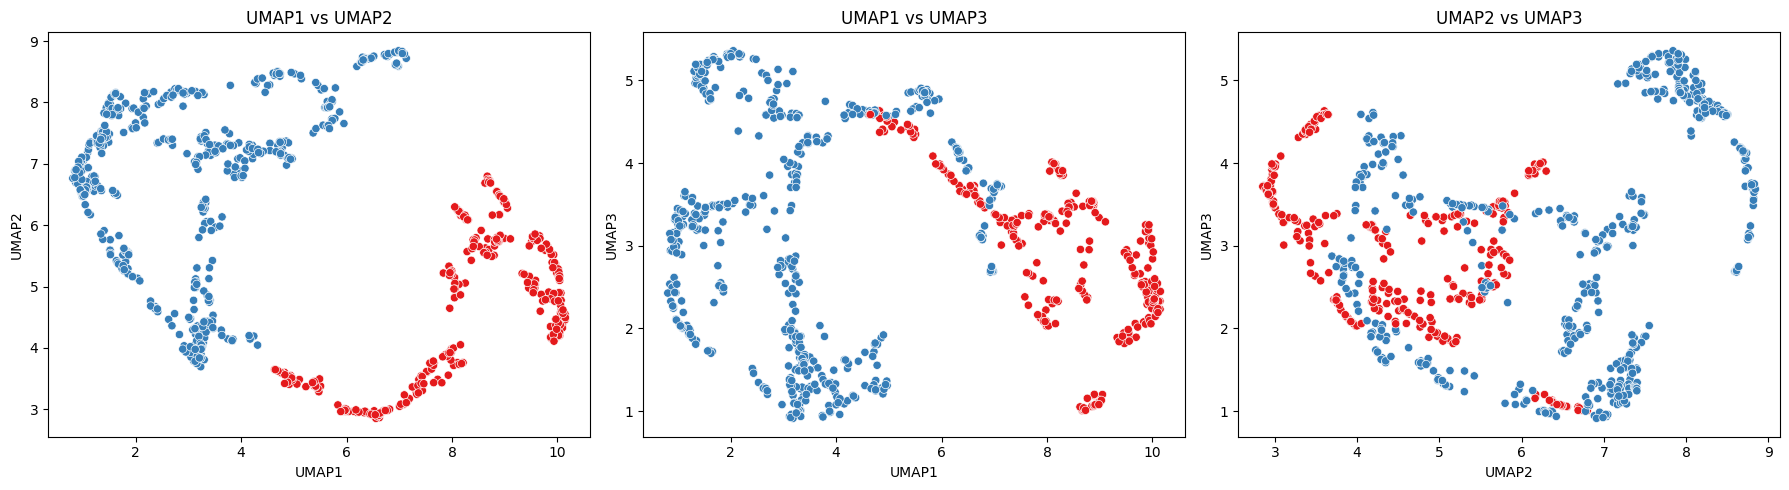

In [282]:
umap_df = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2', 'UMAP3'])
umap_df['cluster'] = labels

# Plot all 3 component combinations in subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='cluster', palette='Set1', ax=axes[0])
axes[0].set_title('UMAP1 vs UMAP2')

sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP3', hue='cluster', palette='Set1', ax=axes[1])
axes[1].set_title('UMAP1 vs UMAP3')

sns.scatterplot(data=umap_df, x='UMAP2', y='UMAP3', hue='cluster', palette='Set1', ax=axes[2])
axes[2].set_title('UMAP2 vs UMAP3')

for ax in axes:
    ax.legend().remove()

plt.tight_layout()
plt.show()

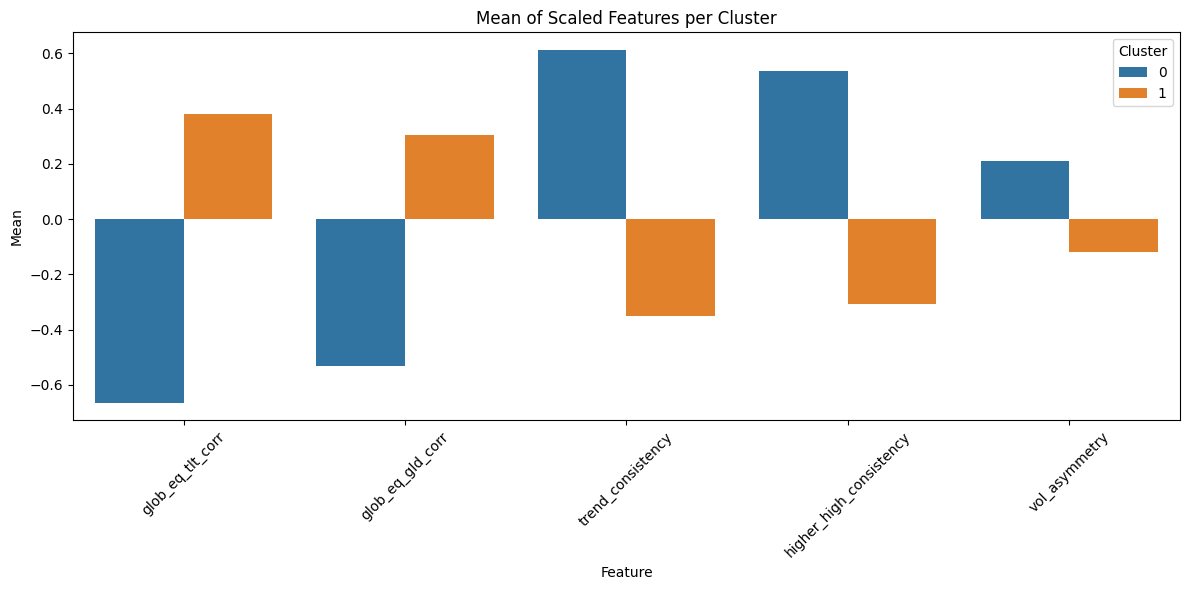

In [283]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a DataFrame with scaled features and labels
df_scaled = pd.DataFrame(scaled, columns=only_bull_features_df.columns)
df_scaled['Cluster'] = labels

# Compute mean of each feature per cluster
cluster_means = df_scaled.groupby('Cluster').mean()

# Reshape for plotting
cluster_means_melted = cluster_means.reset_index().melt(id_vars='Cluster', var_name='Feature', value_name='Mean')

# Plot grouped barplot
plt.figure(figsize=(12, 6))
sns.barplot(data=cluster_means_melted, x='Feature', y='Mean', hue='Cluster')
plt.title('Mean of Scaled Features per Cluster')
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()
